## Finding Critical Reynolds numbers

A brief outline

1. function to compute $\sigma(\mathrm{Re},k)$ 
2. method to interpolate a grid of $\sigma$
3. 2D root finder (likely Newton-Raphson) to find $\sigma(\mathrm{Re},k) = 0$

In [1]:
%matplotlib nbagg

In [2]:
import dedalus.public as de
import numpy as np
import matplotlib.pylab as plt
from scipy import interpolate, optimize

In [3]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

In [4]:
plt.style.use('ggplot')

In [5]:
alpha = 1.02056
Re = 5772.22

In [6]:
z = de.Chebyshev('z',32)
d = de.Domain([z])

orr_somerfeld = de.EVP(d,['w','wz','wzz','wzzz'],'sigma')
orr_somerfeld.parameters['alpha'] = alpha
orr_somerfeld.parameters['Re'] = Re

orr_somerfeld.add_equation('dz(wzzz) - 2*alpha**2*wzz + alpha**4*w - sigma*(wzz-alpha**2*w)-1j*alpha*(Re*(1-z**2)*(wzz-alpha**2*w) + 2*Re*w) = 0 ')
orr_somerfeld.add_equation('dz(w)-wz = 0')
orr_somerfeld.add_equation('dz(wz)-wzz = 0')
orr_somerfeld.add_equation('dz(wzz)-wzzz = 0')

orr_somerfeld.add_bc('left(w) = 0')
orr_somerfeld.add_bc('right(w) = 0')
orr_somerfeld.add_bc('left(wz) = 0')
orr_somerfeld.add_bc('right(wz) = 0')

INFO:problems:Solving EVP with homogeneity tolerance of 1.000e-10


2016-01-15 12:09:45,208 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [7]:
class Eigenproblem():
    def __init__(self, EVP):
        """
        EVP is dedalus EVP object
        """
        self.EVP = EVP
        self.solver = EVP.build_solver()
        
    def solve(self, pencil=0):
        self.solver.solve(self.solver.pencils[pencil], rebuild_coeffs=True)
        self.process_evalues()
            
    def process_evalues(self):
        ev = self.solver.eigenvalues
        self.evalues = ev[np.isfinite(ev)]
    
    def growth_rate(self,params):
        for k,v in params.items():
            vv = self.EVP.namespace[k]
            vv.value = v
        self.solve()
        
        return np.max(self.evalues.real)
    
    def spectrum():
        pass
    
    def reject_spurious():
        """may be able to pull everything out of EVP to construct a new one with higher N..."""
        pass

In [8]:
EP = Eigenproblem(orr_somerfeld)

In [9]:
%%timeit
EP.growth_rate({"alpha":1.,"Re":1000.})

10 loops, best of 3: 69.2 ms per loop


/home/jsoishi/build/dedalus/lib/python3.4/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/home/jsoishi/build/dedalus/lib/python3.4/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta


In [10]:
EP.growth_rate({"alpha":1.,"Re":10000.})

37.358642113446543

In [11]:
(80*80*0.5)/60.

53.333333333333336

In [12]:
class CriticalFinder:
    def __init__(self, func):
        self.func = func
        
    def grid_generator(self, xmin, xmax, ymin, ymax, nx, ny):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.nx = nx
        self.ny = ny
        
        self.yy,self.xx = np.mgrid[self.ymin:self.ymax:self.ny*1j,
                                   self.xmin:self.xmax:self.nx*1j]
        
        self.grid = np.zeros_like(self.xx)
        
        for j,y in enumerate(self.yy[:,0]):
            for i,x in enumerate(self.xx[0,:]):
                self.grid[j,i] = self.func(y,x)


        self.interpolator = interpolate.interp2d(self.xx[0,:], self.yy[:,0], self.grid)
    
    def root_finder(self):
        self.roots = np.zeros_like(self.yy[:,0])
        for j,y in enumerate(self.yy[:,0]):
            try:
                self.roots[j] = optimize.brentq(self.interpolator,self.xx[0,0],self.xx[0,-1],args=(y))
            except ValueError:
                self.roots[j] = np.nan

    def crit_finder(self):
        self.root_finder()
        
        mask = np.isfinite(self.roots)
        yy_root = self.yy[mask,0]
        rroot = self.roots[mask]
        self.root_fn = interpolate.interp1d(yy_root,rroot,kind='cubic')
        
        mid = yy_root.shape[0]/2
        
        bracket = [yy_root[0],yy_root[mid],yy_root[-1]]
        
        self.opt = optimize.minimize_scalar(self.root_fn,bracket=bracket)
        return (self.opt['x'], self.opt['fun'])

In [13]:
def fake_ass_function(x,y):
    return np.exp(-(x**2 + (y-1)**2)) - 0.7

In [14]:
def shim(x,y):
    return EP.growth_rate({"alpha":x,"Re":y})

In [15]:
cf = CriticalFinder(shim)

In [16]:
1-np.sqrt(-np.log(0.7))

0.40277730791711164

In [17]:
%%time
cf.grid_generator(5500,6000,0.95,1.15,40,40)

CPU times: user 1min 52s, sys: 52 ms, total: 1min 52s
Wall time: 1min 52s


In [18]:
cf.root_finder()
crit = cf.crit_finder()
print(crit)

(1.0205253502884335, array(5773.106805285734))


/home/jsoishi/build/dedalus/lib/python3.4/site-packages/ipykernel/__main__.py:43: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


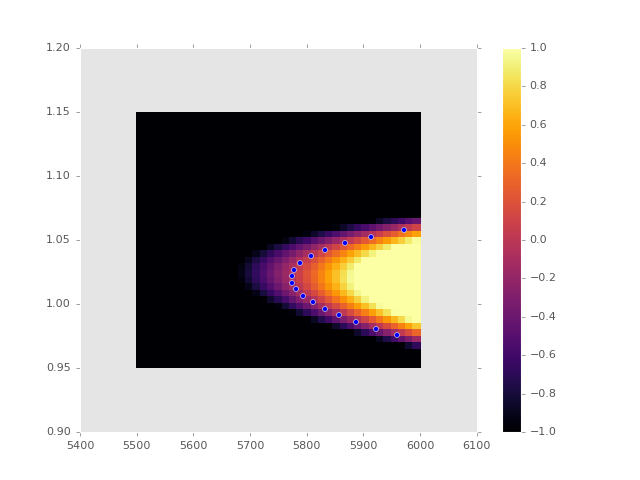

In [19]:
plt.pcolor(cf.xx,cf.yy,cf.grid,cmap='inferno',vmin=-1,vmax=1)
plt.colorbar()
plt.scatter(cf.roots,cf.yy[:,0])
#plt.scatter(crit[1],crit[0],s=60,marker='o',c='yellow')
#plt.axvline(0.40)

#plt.xlim(-1,1)
#plt.ylim(-1,1)

## MRI Testing

Need to load data for MRI, then monkey patch it into the CriticalFinder object.

In [151]:
pwd

'/home/jsoishi/hg-projects/weakly_nonlinear_MRI/python/hartmann'

In [152]:
def get_parameter_space_data(data, allgoodeigs = True):

    Qsearch = data.pop("Qsearch")
    Rmsearch = data.pop("Rmsearch")
    Pm = data.pop("Pm")
    print(Pm)
    q = data.pop("q")
    beta = data.pop("beta")
    dQ = data.pop("dQ")
    dRm = data.pop("dRm")
    
    QRm = np.array(list(itertools.product(Qsearch, Rmsearch)))
    Qs = QRm[:, 0]
    Rms = QRm[:, 1]
    
    ids = np.zeros(len(data))
    evals = np.zeros(len(data), np.complex128)
    
    allRms = np.zeros(len(data))
    allQs = np.zeros(len(data))
    
    if allgoodeigs == False:
        for i in range(len(data)):
            datum = data.popitem()
            if np.isnan(datum[1]) == True:
                evals[i] = None
            else:
                evals[i] = datum[1]
        
            allRms[i] = datum[0][0]
            allQs[i] = datum[0][1]
    else:
        goodeigs = {}
        for i in range(len(data)):
            datum = data.popitem()
            if np.isnan(datum[1][0]) == True:
                evals[i] = None
            else:
                evals[i] = datum[1][0]
        
            allRms[i] = datum[0][0]
            allQs[i] = datum[0][1]
            
            # Store all good eigenvalues
            goodeigs[(allRms[i], allQs[i])] = datum[1][1]
        
    return allRms, allQs, evals

In [156]:
import pickle
import itertools

In [160]:
data = pickle.load(open("../multirun/gridnum_128_Pm_0.01_Q_0.74_dQ_0.001_Rm_4.91_dRm_0.001_allgoodeigs.p","rb"))

In [161]:
Rm, Q, evals = get_parameter_space_data(data)

0.01


<IPython.core.display.Javascript object>


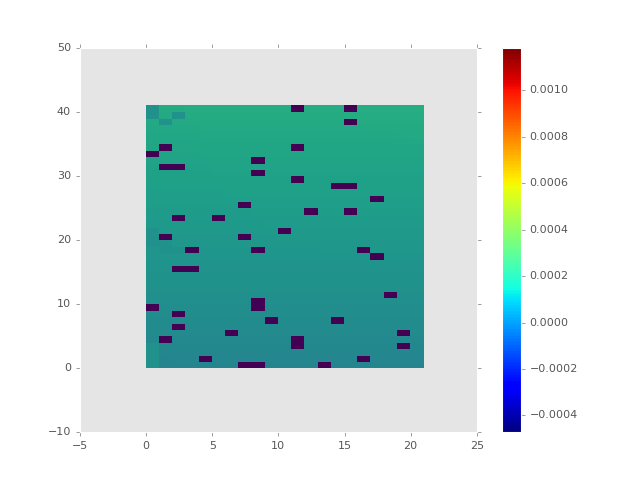

In [217]:
plt.scatter(Q,Rm,c=evals.real)
plt.colorbar()

In [236]:
xx, yy = np.meshgrid(np.unique(Rm),np.unique(Q))

<IPython.core.display.Javascript object>


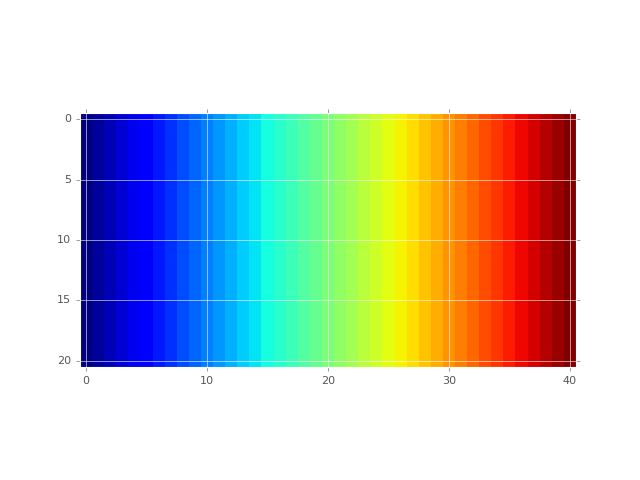

In [245]:
plt.imshow(xx,interpolation='none')

In [237]:
np.unique(Q).shape

(21,)

In [238]:
np.where(yy[:,0] == Rm[0])[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [365]:
ee = np.ones(yy.shape,dtype='complex')*np.nan

In [366]:
for n,e in enumerate(evals):
    yw = np.where(yy[:,0] == Q[n])[0]
    if len(yw) != 1:
        raise ValueError("More than one match for Rm")
    xw = np.where(xx[0,:] == Rm[n])[0]
    if len(xw) != 1:
        raise ValueError("More than one match for Q")
    j = yw[0]
    i = xw[0]
    ee[j,i] = e

In [367]:
np.isnan(ee).sum()

61

In [368]:
plt.pcolor(xx,yy,ee.real,cmap='RdBu',vmin=-0.0001,vmax=0.0001)
plt.colorbar()

In [369]:
a,b = np.where(np.isnan(ee))
ee[a,b] = 0. + 0j
for j,i in zip(a,b):
    partial = 0.+0j
    weight = 0
    

    try:
        partial += ee[j,i-1]
        weight += 1
    except IndexError:
        pass
    try:
        partial += ee[j,i+1]
        weight += 1
    except IndexError:
        pass
    try:
        partial += ee[j-1,i]
        weight += 1
    except IndexError:
        pass
    try:
        partial += ee[j+1,i]
        weight += 1
    except IndexError:
        pass
    if weight == 0:
        raise ValueError
    ee[j,i] = partial/float(weight)

In [370]:
np.isnan(ee).sum()

0

<IPython.core.display.Javascript object>


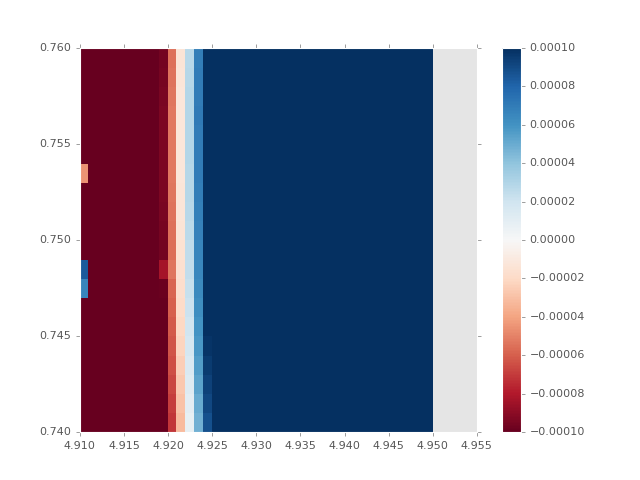

In [371]:
plt.pcolor(xx,yy,ee.real,cmap='RdBu',vmin=-0.0001,vmax=0.0001)
plt.colorbar()

In [348]:
b.size

61

In [391]:
mri_cf = CriticalFinder(None)
mri_cf.xx = xx
mri_cf.yy = yy
mri_cf.grid = ee
mri_cf.interpolator = interpolate.interp2d(mri_cf.xx[0,:], mri_cf.yy[:,0], mri_cf.grid.real)

In [392]:
mri_cf.root_finder()
crit = mri_cf.crit_finder()
print(crit)

(0.75503085448851004, array(4.921288590127938))


/home/jsoishi/build/dedalus/lib/python3.4/site-packages/ipykernel/__main__.py:43: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [387]:
mask = np.isfinite(mri_cf.roots)
mri_cf.roots[mask]

array([ 4.92179742,  4.9217315 ,  4.92167023,  4.92161357,  4.92156152,
        4.92151407,  4.92147119,  4.92136984,  4.92134511,  4.92132487,
        4.92130911,  4.92129783,  4.92129099,  4.92128859,  4.92129062,
        4.92129704,  4.92130869,  4.92132306,  4.92134262])

In [389]:
mri_cf.yy[mask,0]

array([ 0.74 ,  0.741,  0.742,  0.743,  0.744,  0.745,  0.746,  0.749,
        0.75 ,  0.751,  0.752,  0.753,  0.754,  0.755,  0.756,  0.757,
        0.758,  0.759,  0.76 ])

In [376]:
mri_cf.roots

array([ 4.92179742,  4.9217315 ,  4.92167023,  4.92161357,  4.92156152,
        4.92151407,  4.92147119,         nan,         nan,  4.92136984,
        4.92134511,  4.92132487,  4.92130911,  4.92129783,  4.92129099,
        4.92128859,  4.92129062,  4.92129704,  4.92130869,  4.92132306,
        4.92134262])

In [380]:
np.nanmin(mri_cf.roots)

4.9212885922994731